In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import src.common as common
import src.ranking as ranking
import src.data_loading as data_loading
import src.data_transformation as data_transformation
import src.user_profile as user_profile
import src.test as test
import src.visualization as visualization
import traceback

In [2]:
data_loader = data_loading.DataLoader('../data')
movies_df = data_loader.load_movies()
ratings_df = data_loader.load_ratings()

In [3]:
# split the data into train and test sets
train_set, test_set = test.RankingTest.split_ratings_into_train_test(ratings_df.copy(), seed=42, k=10)
movie_rec_df = data_transformation.DataTransformer.transform_data(movies_df, train_set)
results = []

In [4]:
from src.models import AprioriKmeansRecommender, AprioriSimplestRecommender, SimpleRegressionRecommender, SVDRecommender, RidgeKmeansRecommender, KMeansRecommender, CoClusteringRecommender

model = AprioriKmeansRecommender(movie_rec_df, min_support=0.05, k=31, min_confidence=0.6)
model.fit(train_set)
model_pen = AprioriKmeansRecommender(movie_rec_df, min_support=0.05, k=31, min_confidence=0.6, penalize_genres=True)
model_pen.fit(train_set)
simple_recommender = AprioriSimplestRecommender(movie_rec_df, min_support=0.1, min_confidence=0.5)
simple_regression_recommender = SimpleRegressionRecommender(movie_rec_df)
svd_recommender = SVDRecommender(movie_rec_df, n_epochs=25, n_factors=200)
svd_recommender.fit(train_set)
ridge_kmeans_recommender = RidgeKmeansRecommender(movie_rec_df)
ridge_kmeans_recommender.fit(train_set)
kmeans_recommender = KMeansRecommender(movie_rec_df, k=15)
kmeans_recommender.fit(train_set)
co_clustering_recommender = CoClusteringRecommender(movie_rec_df, n_cltr_u=11, n_cltr_i=5)
co_clustering_recommender.fit(train_set)



In [5]:
# from src.common import load_model
# svd_recommender = load_model("../model/svdpp_rec.pkl")

In [6]:
models: dict[str, object] = {
    'AprioriKmeansRecommender_no_pen': model,
    'AprioriKmeansRecommender_pen': model_pen,
    'AprioriSimplestRecommender': simple_recommender,
    'SimpleRegressionRecommender': simple_regression_recommender,
    'SVDRecommender': svd_recommender,
    'RidgeKmeansRecommender': ridge_kmeans_recommender,
    'KMeansRecommender': kmeans_recommender,
    'CoClusteringRecommender': co_clustering_recommender,
}


result_dict = {
    'AprioriKmeansRecommender_no_pen': {'spearman': [], 'mrr': []},
    'AprioriKmeansRecommender_pen': {'spearman': [], 'mrr': []},
    'AprioriSimplestRecommender': {'spearman': [], 'mrr': []},
    'SimpleRegressionRecommender': {'spearman': [], 'mrr': []},
    'SVDRecommender': {'spearman': [], 'mrr': []},
    'RidgeKmeansRecommender': {'spearman': [], 'mrr': []},
    'KMeansRecommender': {'spearman': [], 'mrr': []},
    'CoClusteringRecommender': {'spearman': [], 'mrr': []}
}

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
i = 0
for test_user in test_set['userId'].unique().tolist():
    test_user_ratings = train_set[train_set['userId'] == test_user]
    evaluation_ratings = test_set[test_set['userId'] == test_user]
    for (key, m) in models.items():
        recommendations = m.recommend_for_user(test_user_ratings, test_user, evaluation_ratings=evaluation_ratings, top_n=len(evaluation_ratings))
        corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
        result_dict[key]['spearman'].append(corr)
        recommendations = m.recommend_for_user(test_user_ratings, test_user, top_n=100)
        mrr = test.RankingTest.calculate_rr(evaluation_ratings, recommendations)
        result_dict[key]['mrr'].append(mrr)
    i += 1
    if i > 2000:
        break


C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\

KeyboardInterrupt: 

In [8]:
res_map = []
for (key, val) in result_dict.items():
    res = [r for r in val['spearman'] if r is not np.nan]
    res_map.append((res, key))

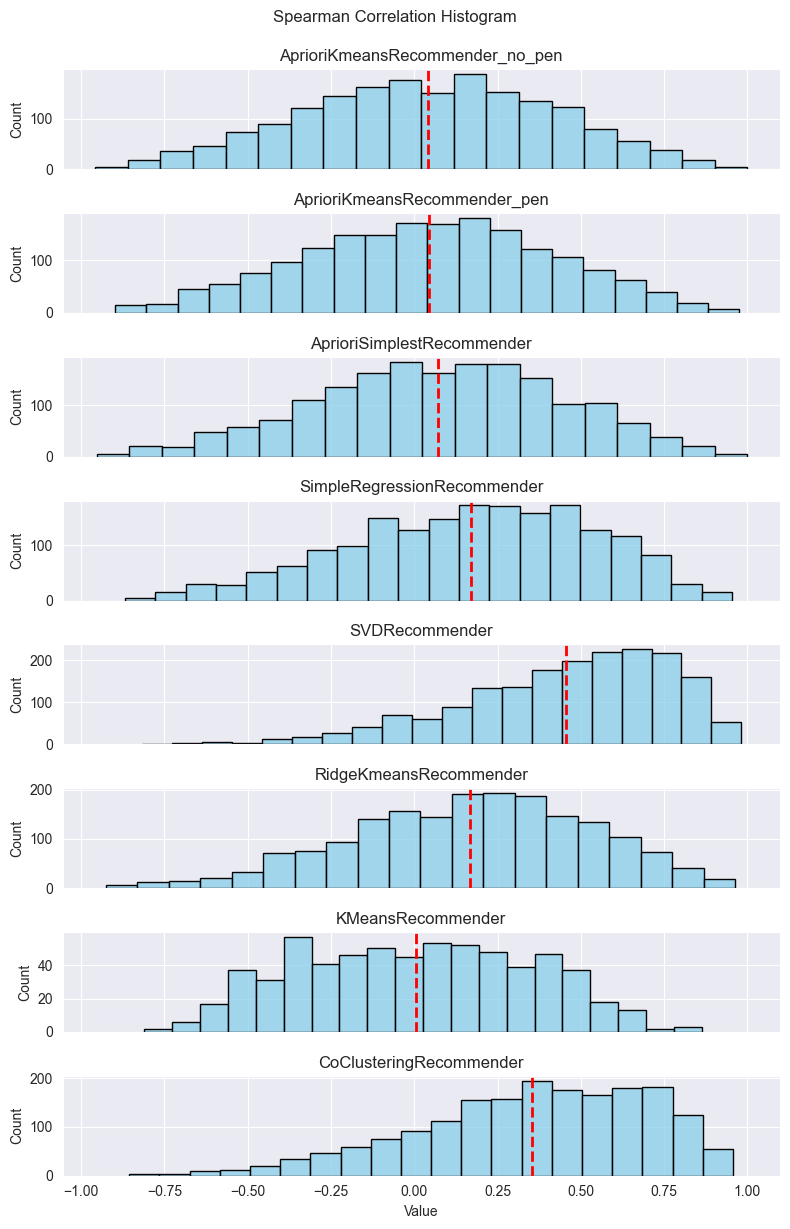

In [9]:
visualization.visualize_multiple_hist(res_map, "Spearman Correlation Histogram")

In [10]:
for (key, val) in result_dict.items():
    print(key, np.mean([r for r in val['spearman'] if r is not np.nan]))

AprioriKmeansRecommender_no_pen 0.04172020252916919
AprioriKmeansRecommender_pen 0.043660244565972964
AprioriSimplestRecommender 0.07186097283732748
SimpleRegressionRecommender 0.16898116137068664
SVDRecommender 0.45433993526048716
RidgeKmeansRecommender 0.16883406231640807
KMeansRecommender 0.004786094141193784
CoClusteringRecommender 0.3542509295243239


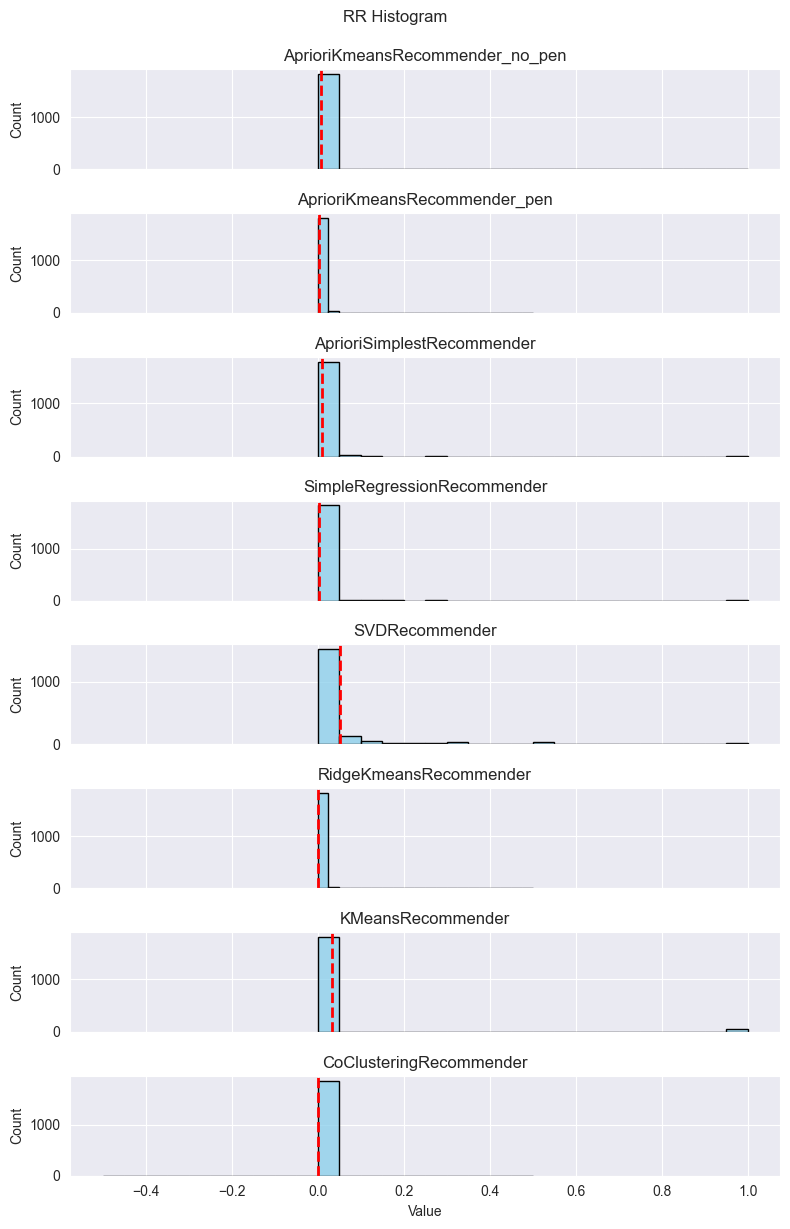

In [13]:
res_map = []
for (key, val) in result_dict.items():
    res = [r for r in val['mrr'] if r is not np.nan]
    res_map.append((res, key))
visualization.visualize_multiple_hist(res_map, "RR Histogram")

In [12]:
for (key, val) in result_dict.items():
    print(key, np.mean([r for r in val['mrr'] if r is not np.nan]))

AprioriKmeansRecommender_no_pen 0.006894512443452233
AprioriKmeansRecommender_pen 0.0029859692175718574
AprioriSimplestRecommender 0.011191642010865015
SimpleRegressionRecommender 0.004127527963457461
SVDRecommender 0.052183276988204914
RidgeKmeansRecommender 0.001551820738009107
KMeansRecommender 0.03279051086349325
CoClusteringRecommender 0.0


In [13]:
# from src.common import save_model
#
# save_model(co_clustering_recommender, "../model/co_clustering.pkl")